In [35]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


In [36]:
pas="1"
config="2"

# Quasi-Elastic Cuts 

In [37]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
nBins=CONFIG.Function_JSON("nBins",f"../config/cuts{config}.cfg")

#kin3
#dymin=-.7895
#dymax=.7895
#W2max=1.5
#dybgmin=-1.2
#dybgmax=1.2
#dxmin=-.5
#dxmax=.5
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'nBins: {nBins}')
#nBins=150
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: 0
W2max: 1.5
dxmin: -0.481
dxmax: 0.498
dymin: -0.822
dymax: 0.8
dybgmin: -1.4
dybgmax: 1.4
nBins: 150
Coin Min: 91 Coin Max: 109


In [38]:

def asymmetrySIMFIT(config):
    r.gErrorIgnoreLevel = r.kError  # Suppress Info and Warning messages
    gStyle.SetOptStat(0)
    gStyle.SetOptFit(1)

    #_____bring in config values______#
    coinVector=CONFIG.Function_JSON("GEN"+config,"../config/coin.cfg")
    he3spot=CONFIG.Function_JSON("GEN"+config+"He3","../config/spotsize.cfg")
    he3spotsim=CONFIG.Function_JSON("GEN"+config+"He3sim","../config/spotsize.cfg")
    
    #here, set coincidence cut and spot cut values
    coinSigma=2.5
    coin_low=coinVector[0]-coinSigma*coinVector[1]
    coin_high=coinVector[0]+coinSigma*coinVector[1]

    #spot imports for dx,dy high and low
    
    hiydata=he3spot[1];
    lowydata=he3spot[0];
    
    hixdatan=he3spotsim[7];
    lowxdatan=he3spotsim[6];
    hixdatap=he3spotsim[5];
    lowxdatap=he3spotsim[4];
    
    hix_n_3 = he3spotsim[7]
    lowx_n_3 = he3spotsim[6]
    hix_p_3 = he3spotsim[5]
    lowx_p_3 = he3spotsim[4]
    hiy_p3 = he3spotsim[1]
    lowy_p3 = he3spotsim[0]
    hiy_n3 = he3spotsim[3]
    lowy_n3 = he3spotsim[2]
    

    rxn3 = (hix_n_3 - lowx_n_3) / 2.0
    rxp3 = (hix_p_3 - lowx_p_3) / 2.0
    ryp3 = (hiy_p3 - lowy_p3) / 2.0
    ryn3 = (hiy_n3 - lowy_n3) / 2.0



    x0_n3 = (hix_n_3 + lowx_n_3) / 2.0
    x0_p3 = (hix_p_3 + lowx_p_3) / 2.0
    y0_3 = (hiy_p3 + lowy_p3) / 2.0


    
    #-------------------------------------
    rootfilenp = (f"../outfiles/Pass1/QE_data_GEN{config}_sbs100p_nucleon_np_model2.root")
    rootfilep = (f"../outfiles/Pass1/QE_sim_GEN{config}_sbs100p_nucleon_np_model2.root")
    
    
    C = TChain("Tout")
    B = TChain("Tout")
    
    C.Add(rootfilenp)
    B.Add(rootfilep)

    dx_p, dy_p, W2_p, coin_p,fnucl  = array.array('d', [0]),array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    dx_np, dy_np, W2_np, coin_np, weight = array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0]), array.array('d', [0])
    helicity_p, IHWP_p, runnum_p = array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    helicity_np, IHWP_np, runnum_np= array.array('i', [0]), array.array('i', [0]), array.array('i', [0])
    
    # Disable all branches initially
    C.SetBranchStatus("*", 0)
    B.SetBranchStatus("*", 0)

    # Enable specific branches
    branches = ["dx", "dy", "W2", "helicity", "IHWP", "runnum", "coinCut", "coin_time"]
    b2=["dx", "dy", "W2"]
    for branch in branches:
        C.SetBranchStatus(branch, 1)
    for branch in b2:
        B.SetBranchStatus(branch, 1)

    B.SetBranchStatus("weight", 1)
    B.SetBranchStatus("fnucl",1)
    # Set branch addresses
    C.SetBranchAddress("dx", dx_np)
    B.SetBranchAddress("dx", dx_p)
    C.SetBranchAddress("dy", dy_np)
    B.SetBranchAddress("dy", dy_p)
    C.SetBranchAddress("W2", W2_np)
    B.SetBranchAddress("W2", W2_p)
    C.SetBranchAddress("helicity", helicity_np)
    #B.SetBranchAddress("helicity", helicity_p)
    C.SetBranchAddress("IHWP", IHWP_np)
    #B.SetBranchAddress("IHWP", IHWP_p)
    C.SetBranchAddress("coin_time", coin_np)
    #B.SetBranchAddress("coin_time", coin_pp)
    C.SetBranchAddress("runnum", runnum_np)
    #B.SetBranchAddress("runnum", runnum_p)
    B.SetBranchAddress("weight", weight)
    B.SetBranchAddress("fnucl", fnucl)
    
    # Assuming the variables are already defined or loaded from the ROOT file
    nbins=nBins    
    xmin, xmax = -4, 2.5
    if config=="2":
        xmin=-5.5
        xmax=2.8
    
    hdx_total_data = TH1F("hdx_total_data", "#Deltax;#Deltax;Entries", nbins, xmin, xmax)
    hdx_total_sim = TH1F("hdx_total_sim", "#Deltax;#Deltax;Entries", 100, -6, 4)
    hdx_p = TH1F("hdx_p", "#Deltax for helicity +1;#Deltax;Entries", 100, -6, 4)
    hdx_m = TH1F("hdx_m", "#Deltax for helicity -1;#Deltax;Entries", 100, -6, 4)
    
    hdx_data_plus = TH1F("hdx_data_plus", "", nbins, xmin, xmax)
    hdx_data_minus = TH1F("hdx_data_minus", "", nbins, xmin, xmax)
    hdx_sim_p = TH1F("hdx_sim_p", "", nbins, xmin, xmax)
    hdx_sim_n = TH1F("hdx_sim_n", "", nbins, xmin, xmax)
    hdx_bg_data = TH1F("hdx_bg_data", "", nbins, xmin, xmax)
    hdx_bg_data_plus = TH1F("hdx_bg_data_plus", "", nbins, xmin, xmax)
    hdx_bg_data_minus = TH1F("hdx_bg_data_minus", "", nbins, xmin, xmax)
    

    nEntries_np = C.GetEntries()
    for i in range(nEntries_np):
        C.GetEntry(i)
        if IHWP_np[0] == 1:
            helicity_np[0] *= -1
        elif IHWP_np[0] == -1:
            helicity_np[0] *= 1
        else:
            continue
            
#____________CUTS_______________________________      
        ycut = dymin < dy_np[0] < dymax
        bgycut=dybgmin<dy_np[0]<dybgmax
        coin_cut = coinmin < coin_np[0] < coinmax
        W2cut=W2min < W2_np[0] < W2max
#________________________________________________     

        if coin_cut and W2cut and runnum_np[0] > 2165 and not bgycut:
            hdx_bg_data.Fill(dx_np[0])
            if helicity_np[0] == 1:
                hdx_bg_data_plus.Fill(dx_np[0])
            if helicity_np[0] == -1:
                hdx_bg_data_minus.Fill(dx_np[0])

        if coin_cut and W2cut and runnum_np[0] > 2165 and ycut:
            hdx_total_data.Fill(dx_np[0])
            if helicity_np[0] == 1:
                hdx_data_plus.Fill(dx_np[0])
            if helicity_np[0] == -1:
                hdx_data_minus.Fill(dx_np[0])
    
    # Simulation loop
    nEntries_p = B.GetEntries()
    
    for i in range(nEntries_p):
        B.GetEntry(i)
        

        #ncut = (dx_p[0] - x0_n3)**2 / rxn3**2 + (dy_p[0] - y0_3)**2 / ryn3**2 <= 1
        #pcut = (dx_p[0] - x0_p3)**2 / rxp3**2 + (dy_p[0] - y0_3)**2 / ryp3**2 <= 1
        ##temp testing-------------------------------
       # ycut = lowydata < dy_p[0] < hiydata
        #xcutn = lowxdatan < dx_p[0] < hixdatan
       # #xcutp = lowxdatap < dx_p[0] < hixdatap
        ######---------------------------------------
                
        #____________CUTS_______________________________      
        ycut = dymin < dy_p[0] < dymax
        W2cut=W2min < W2_p[0] < W2max
        #________________________________________________ 
        
        #temp replace pcut with ycut+xcut
        #print(fnucl)
        #if W2_p[0] < W2max and ycut and fnucl[0]==1:
        #    hdx_sim_p.Fill(dx_p[0], weight[0])
        #if W2_p[0] < W2max and ycut and fnucl[0]==0:
        #    hdx_sim_n.Fill(dx_p[0], weight[0])
        if W2cut and ycut and fnucl[0]==1:
            hdx_sim_p.Fill(dx_p[0], weight[0])
        if W2cut and ycut and fnucl[0]==0:
            hdx_sim_n.Fill(dx_p[0], weight[0])
    
    

    # Fit distributions
    cfg = f"GEN{config}"
    print(cfg)
    
    dists = DistributionFits(bg_shape_option="pol4" if cfg == "GEN2" or cfg== "GEN3" else "from data")
    dists.hdx_data = (np.array([hdx_total_data.GetBinCenter(i) for i in range(1, hdx_total_data.GetNbinsX() + 1)]), 
                      np.array([hdx_total_data.GetBinContent(i) for i in range(1, hdx_total_data.GetNbinsX() + 1)]))
    dists.hdx_sim_p = (np.array([hdx_sim_p.GetBinCenter(i) for i in range(1, hdx_sim_p.GetNbinsX() + 1)]), 
                       np.array([hdx_sim_p.GetBinContent(i) for i in range(1, hdx_sim_p.GetNbinsX() + 1)]))
    dists.hdx_sim_n = (np.array([hdx_sim_n.GetBinCenter(i) for i in range(1, hdx_sim_n.GetNbinsX() + 1)]), 
                       np.array([hdx_sim_n.GetBinContent(i) for i in range(1, hdx_sim_n.GetNbinsX() + 1)]))
    dists.hdx_bg_data = (np.array([hdx_bg_data.GetBinCenter(i) for i in range(1, hdx_bg_data.GetNbinsX() + 1)]), 
                         np.array([hdx_bg_data.GetBinContent(i) for i in range(1, hdx_bg_data.GetNbinsX() + 1)]))

    hdx_bg_fit, hdx_total_fit, hdx_sim_p, hdx_sim_n = dists.He3_fit_dists()
    # Plot results
    hdx_data_plot = hdx_total_data.Clone("hdx_data_plot")
    #hdx_sim_p_plot = hdx_sim_p.Clone("hdx_sim_p_plot")
    #hdx_sim_n_plot = hdx_sim_n.Clone("hdx_sim_n_plot")
    hdx_sim_p_plot = TH1F("hdx_sim_p_plot", "", nbins, xmin, xmax)
    hdx_sim_n_plot = TH1F("hdx_sim_n_plot", "", nbins, xmin, xmax)
    hdx_bg_plot = TH1F("hdx_bg_plot", "", nbins, xmin, xmax)
    hdx_total_fit_plot = TH1F("hdx_total_fit_plot", "", nbins, xmin, xmax)

    for i in range(nbins):
        hdx_bg_plot.SetBinContent(i + 1, hdx_bg_fit[i])
        hdx_total_fit_plot.SetBinContent(i + 1, hdx_total_fit[i])
        hdx_sim_p_plot.SetBinContent(i + 1, hdx_sim_p[i])
        hdx_sim_n_plot.SetBinContent(i + 1, hdx_sim_n[i])

    gStyle.SetOptFit(0)
    
    hdx_data_plot.SetTitle(f"Data/Simulation Comparison {cfg};#Deltax (m);Entries")
    hdx_data_plot.SetMarkerStyle(r.kFullCircle)
    hdx_total_fit_plot.SetFillColorAlpha(30, 0.5)
    hdx_sim_p_plot.SetFillColorAlpha(r.kRed, 0.3)
    hdx_sim_n_plot.SetFillColorAlpha(r.kBlue, 0.3)
    hdx_bg_plot.SetFillColorAlpha(r.kMagenta, 0.3)
    
    hdx_total_fit_plot.SetLineStyle(7)
    hdx_sim_p_plot.SetLineStyle(7)
    hdx_sim_n_plot.SetLineStyle(7)
    hdx_bg_plot.SetLineStyle(7)
    
    hdx_total_fit_plot.SetLineColor(30)
    hdx_sim_p_plot.SetLineColor(r.kRed)
    hdx_sim_n_plot.SetLineColor(r.kBlue)
    hdx_bg_plot.SetLineColor(r.kMagenta)
    
    c = TCanvas("c", "", 800, 600)
    hdx_data_plot.Draw()
    hdx_total_fit_plot.Draw("same hist")
    hdx_sim_p_plot.Draw("same hist")
    hdx_sim_n_plot.Draw("same hist")
    hdx_bg_plot.Draw("same hist")
    
    legend = TLegend(0.65, 0.72, 0.89, 0.89)
    legend.AddEntry("hdx_data_plot", "Data", "p")
    legend.AddEntry("hdx_total_fit_plot", "MC Fit", "lf")
    legend.AddEntry("hdx_sim_p_plot", "MC p", "lf")
    legend.AddEntry("hdx_sim_n_plot", "MC n", "lf")
    legend.AddEntry("hdx_bg_plot", "Background", "lf")
    legend.SetLineColor(0)
    legend.Draw("same")
    
    output = f"Data_sim_total_{cfg}.pdf"
    #c.SaveAs(f"../plots/{output}")
    return Function_HIST2NP(hdx_data_plot), Function_HIST2NP(hdx_bg_plot),Function_HIST2NP(hdx_total_fit_plot),Function_HIST2NP(hdx_sim_p_plot),Function_HIST2NP(hdx_sim_n_plot)




# Run fit function and extract histograms

In [39]:
save=asymmetrySIMFIT(config)

GEN2


Error in <THashList::Delete>: A list is accessing an object (0xab4c1e0) already deleted (list name = THashList)


In [40]:
he3spot=CONFIG.Function_JSON("GEN"+config+"He3","../config/spotsize.cfg")
hixdatan=he3spot[7];
lowxdatan=he3spot[6];

In [41]:
data,bgHist,totalHist,simpHist,simnHist = save

In [42]:
np.save(f'SavedArrays/GEN{config}/Pass1/GEN{config}simfit1.npy', {
    'data': data,
    'bgHist': bgHist,
    'totalHist': totalHist,
    'simpHist':simpHist,
    'simnHist':simnHist,
},allow_pickle=True)

# Fit the neutron peak to determine quasicut

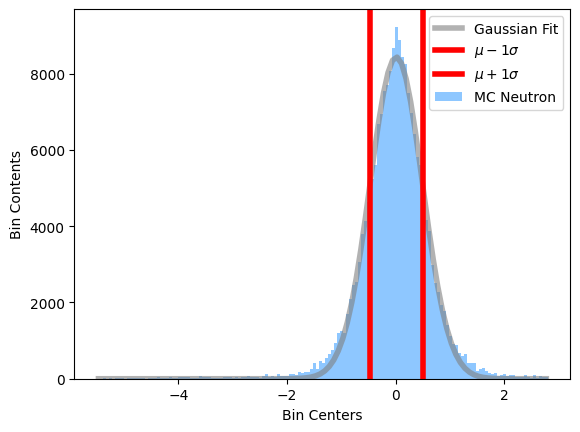

Mean: 0.0101, Standard Deviation (Sigma): 0.4828827658146618
Number of events within ±1 sigma: 123538.5879
dxmin: -0.473
dxmax: 0.493


In [43]:
bin_centers,bin_contents=simnHist
sigcut=1
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

initial_guess = [max(bin_contents), bin_centers[np.argmax(bin_contents)], 1.0]

popt, pcov = curve_fit(gaussian, bin_centers, bin_contents, p0=initial_guess)

amplitude, mean, stddev = popt

plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5, color="dodgerblue", label="MC Neutron")
x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, color='grey', linewidth=4,alpha=.6, label='Gaussian Fit')
plt.axvline(mean -sigcut * stddev, color='red', linewidth=4, label=f'$\mu - {sigcut}\sigma$')
plt.axvline(mean + sigcut * stddev, color='red', linewidth=4, label=f'$\mu + {sigcut}\sigma$')

plt.xlabel('Bin Centers')
plt.ylabel('Bin Contents')
plt.legend()
plt.show()
lower_bound = mean -sigcut * stddev
upper_bound = mean + sigcut * stddev

within_3sigma = np.sum(bin_contents[(bin_centers >= lower_bound) & (bin_centers <= upper_bound)])
print(f"Mean: {np.round(mean,4)}, Standard Deviation (Sigma): {stddev}")
print(f"Number of events within ±{sigcut} sigma: {np.round(within_3sigma,4)}")
print(f'dxmin: {np.round(lower_bound,3)}')
print(f'dxmax: {np.round(upper_bound,3)}')

# Create pretty plot

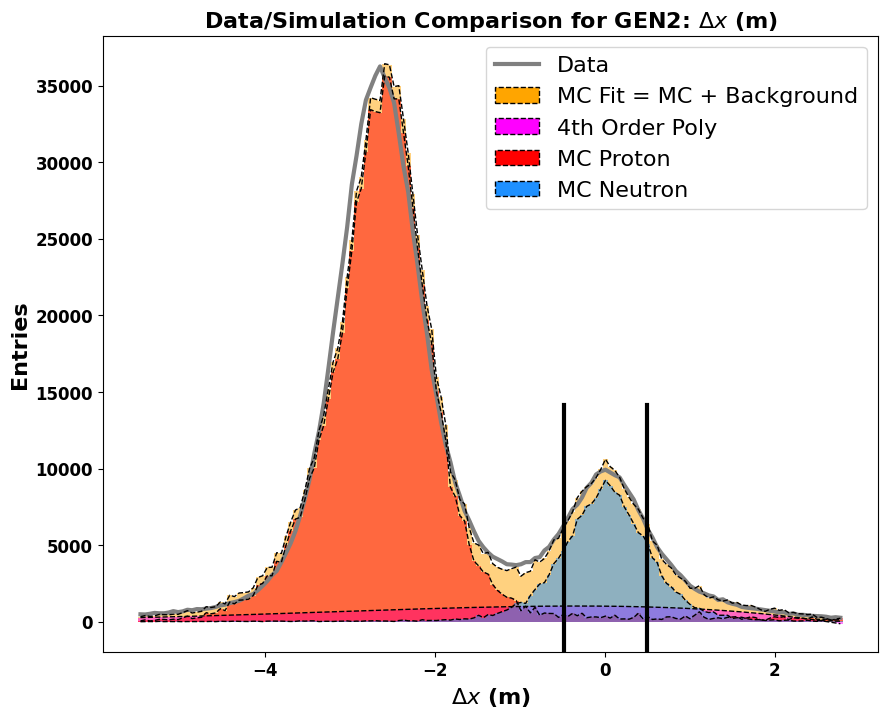

194105.99451732635

In [44]:
bin_centers,bin_contents=bgHist
plt.figure(figsize=(10,8))
lw=1.6
l=3
if config=="2":
    lw=1
    l=3
fs=16
fw='bold'

#____________Data___________________________________________________________________________________________
bin_centers,bin_contents=data
plt.plot(bin_centers, bin_contents,'-',color='grey',linewidth=l,label='Data')
#___________________________________________________________________________________________________________



#____________Total Fit = SimP + SimN + Background___________________________________________________________
bin_centers,bin_contents=totalHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='orange',label="Total Fit = bg+simN+simP")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

#____________Background_____________________________________________________________________________________
bin_centers,bin_contents=bgHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color='magenta',label="Background Data")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________


#____________Simulated Proton_______________________________________________________________________________
bin_centers,bin_contents=simpHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color="red",label="MC Proton")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________


#____________Simulated Neutron______________________________________________________________________________
bin_centers,bin_contents=simnHist
plt.bar(bin_centers, bin_contents, width=(bin_centers[1] - bin_centers[0]), align='center', alpha=0.5,color="dodgerblue",label="MC Neutron")
plt.plot(bin_centers, bin_contents,'--',color='black',linewidth=lw)
#___________________________________________________________________________________________________________

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
typ="Background Data"
if config=="2" or config=="3":
    typ="4th Order Poly"
#_________________Special Legend Including Dotted Black Border______________________________________________
a=1
legend_elements = [
    Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
    Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
    Patch(facecolor='magenta', edgecolor='black', linestyle='--', label=typ, alpha=a),
    Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
    Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
]
#___________________________________________________________________________________________________________

plt.axvline(dxmin, color='black', linewidth=3,ymax=.4, label=r'$\mu - 3\sigma$')
plt.axvline(dxmax, color='black', linewidth=3,ymax=.4, label=r'$\mu + 3\sigma$')
#print(f'{upper} {lower}')
plt.title(f'Data/Simulation Comparison for GEN{config}: $\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.legend(handles=legend_elements,loc='upper right',fontsize=fs)
plt.xticks(fontsize=fs-4, fontweight=fw)
plt.yticks(fontsize=fs-4, fontweight=fw)
plt.xlabel(r'$\Delta x$ (m)',fontsize=fs,fontweight=fw)
plt.ylabel('Entries',fontsize=fs,fontweight=fw)
plt.savefig(f'../plots/DataSimPass{pas}GEN{config}.png')
plt.show()
np.sum(bin_contents)

# EXTRA

In [45]:
s=16000
bg=16000

s/(np.sqrt(s+bg))

89.44271909999158

In [46]:
s=10000
bg=50000
s/(np.sqrt(s+bg))

40.8248290463863

In [47]:
np.sqrt(2000)

44.721359549995796